# **K-Means**

O notebook tem como objetivo explorar o algoritmo de clustering K-means aplicado a um contexto diferente do usual, vou usar dados biológicos para segmentar diferentes espécies de pinguins com base em características físicas. Esta abordagem destaca a versatilidade do K-means.

A base de dados utilizada é a penguins do pacote seaborn, que contém informações sobre três espécies de pinguins: Adelie, Chinstrap e Gentoo. As variáveis disponíveis incluem medições físicas dos pinguins coletadas na Antártica.

**species**: Espécie do pinguim (Adelie, Chinstrap, Gentoo)

**island**: Ilha onde o pinguim foi observado (Biscoe, Dream, Torgersen)

**bill_length_mm**: Comprimento do bico em milímetros

**bill_depth_mm**: Profundidade do bico em milímetros

**flipper_length_mm**: Comprimento da barbatana em milímetros

**body_mass_g**: Massa corporal em gramas

**sex**: Sexo do pinguim (Male, Female)

**year**: Ano em que a observação foi feita

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

In [2]:
penguins = sns.load_dataset('penguins')

In [3]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


## 1 - Verificando variáveis missing, faltantes e excluir esses valores do dataset, e também as colunas com valores categóricos.

In [6]:
# 1 - Remover missing e colunas categóricas não usadas pelo KMeans
penguins_clean = penguins.dropna().copy()
print("Shape original:", penguins.shape)
print("Shape após dropna:", penguins_clean.shape)
cols_to_drop = ['species', 'island', 'sex']
for c in cols_to_drop:
    if c in penguins_clean.columns:
        penguins_clean = penguins_clean.drop(columns=c)
# Selecionar apenas colunas numéricas que usaremos no KMeans
X = penguins_clean.select_dtypes(include=['number']).copy()
print("Colunas usadas para KMeans:", X.columns.tolist())
X.head()

Shape original: (344, 7)
Shape após dropna: (333, 7)
Colunas usadas para KMeans: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


## 2 - Visualizando a análise descritiva dos dados. 

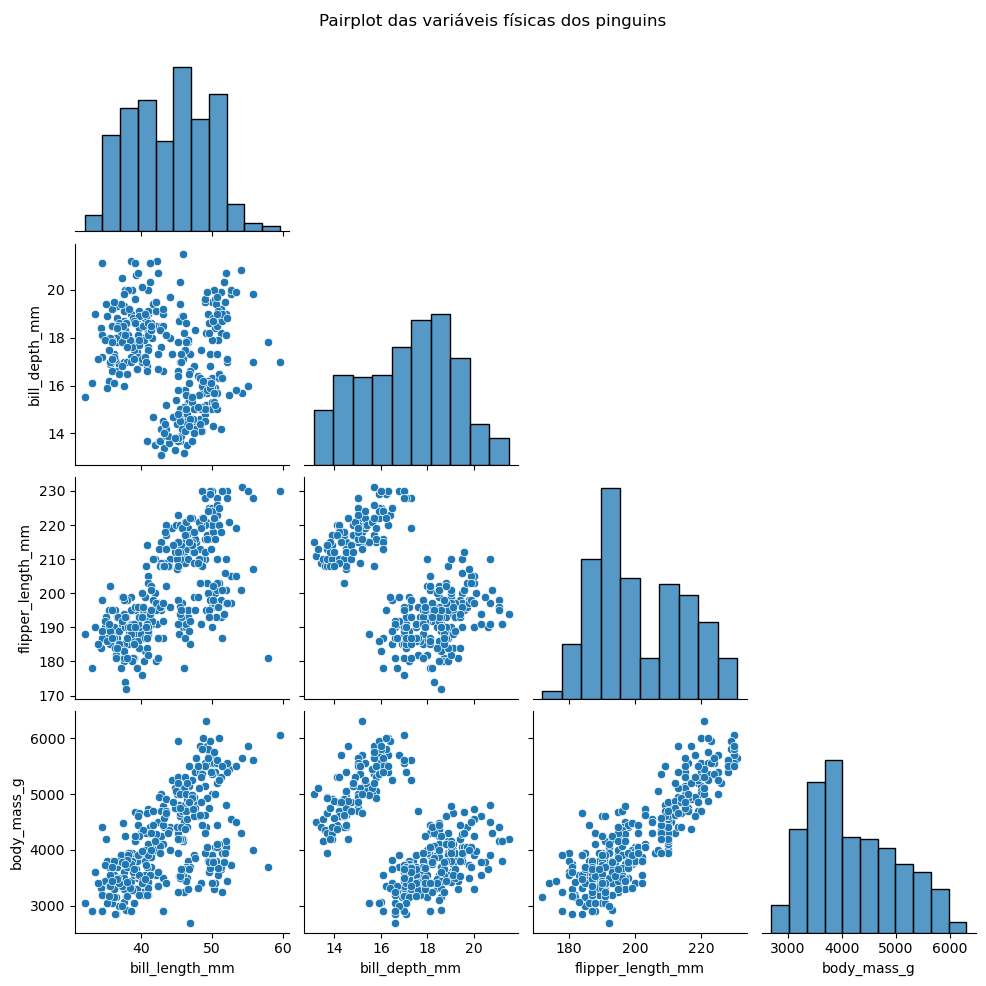

In [19]:
# 2 - Pairplot para análise descritiva
vars_plot = ['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']
sns.pairplot(penguins_clean, vars=vars_plot, corner=True)
plt.suptitle('Pairplot das variáveis físicas dos pinguins')
plt.show()

**Análise**

Ë possível identificar que existem até 3 grupos diferentes quando comparamos o comprimento da barbatama com o comprimento do bicoe o mesmo se aplica para a comparação do comprimento e profundidade do bico. Nos demais plots não é possivel notar tanta separação.

## 3 - Padronização e Visualize dos Dados.

In [15]:
# Selecionar as colunas numéricas que usamos acima (garantindo consistência)
X_numeric = penguins.dropna()[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns, index=X_numeric.index)
print('Média (por coluna) após padronizar (aprox):', X_scaled_df.mean().round(4).to_dict())
print('Std (por coluna) após padronizar (aprox):', X_scaled_df.std().round(4).to_dict())
X_scaled_df.head()

Média (por coluna) após padronizar (aprox): {'bill_length_mm': 0.0, 'bill_depth_mm': 0.0, 'flipper_length_mm': 0.0, 'body_mass_g': -0.0}
Std (por coluna) após padronizar (aprox): {'bill_length_mm': 1.0015, 'bill_depth_mm': 1.0015, 'flipper_length_mm': 1.0015, 'body_mass_g': 1.0015}


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-0.896042,0.780732,-1.426752,-0.568475
1,-0.822788,0.119584,-1.069474,-0.506286
2,-0.676280,0.424729,-0.426373,-1.190361
4,-1.335566,1.085877,-0.569284,-0.941606
5,-0.859415,1.747026,-0.783651,-0.692852


## **4 - K-Means**

In [16]:
# 4 - Aplicar KMeans com k=3
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
# usar X_scaled (gerado na célula anterior)
kmeans.fit(X_scaled)
labels = kmeans.labels_
print('Inertia (Soma dos quadrados intra-cluster):', kmeans.inertia_)
print('Contagem por cluster:')
print(pd.Series(labels).value_counts())
# juntar labels ao dataframe original (com dropna())
penguins_labeled = penguins.dropna().copy()
penguins_labeled['cluster'] = labels
penguins_labeled.head()

Inertia (Soma dos quadrados intra-cluster): 370.766143513507
Contagem por cluster:
0    129
1    119
2     85
Name: count, dtype: int64


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,cluster
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male,0


## 5 - Matriz de Dispersão

In [17]:
# 5 - Matrizes de dispersão com pontos e centroides
# Recuperar centróides em escala original (inverter a transformação)
centers_scaled = kmeans.cluster_centers_
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=X_numeric.columns)

# Gráfico 1: bill_length_mm x bill_depth_mm
fig = px.scatter(penguins_labeled, x='bill_length_mm', y='bill_depth_mm', color=penguins_labeled['cluster'].astype(str),
                 title='Clusters: bill_length_mm vs bill_depth_mm', labels={'color':'cluster'})
fig.add_trace(go.Scatter(x=centers_df['bill_length_mm'], y=centers_df['bill_depth_mm'],
                         mode='markers', marker=dict(symbol='x', size=12, color='black'), name='centroids'))
fig.show()

# Gráfico 2: flipper_length_mm x body_mass_g
fig2 = px.scatter(penguins_labeled, x='flipper_length_mm', y='body_mass_g', color=penguins_labeled['cluster'].astype(str),
                 title='Clusters: flipper_length_mm vs body_mass_g', labels={'color':'cluster'})
fig2.add_trace(go.Scatter(x=centers_df['flipper_length_mm'], y=centers_df['body_mass_g'],
                         mode='markers', marker=dict(symbol='x', size=12, color='black'), name='centroids'))
fig2.show()

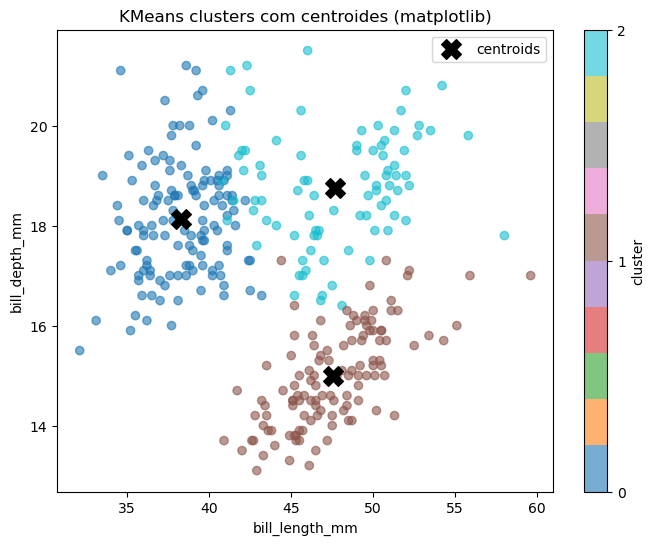

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
# pontos coloridos pelo cluster
scatter = ax.scatter(penguins_labeled['bill_length_mm'], penguins_labeled['bill_depth_mm'],
                     c=penguins_labeled['cluster'], cmap='tab10', alpha=0.6)

# centroides (em escala original) marcados com X preto
ax.scatter(centers_df['bill_length_mm'], centers_df['bill_depth_mm'],
           marker='X', s=200, c='black', label='centroids')

ax.set_xlabel('bill_length_mm')
ax.set_ylabel('bill_depth_mm')
ax.set_title('KMeans clusters com centroides (matplotlib)')
# adicionar legenda para centroides
ax.legend()
# adicionar colorbar para visualizar os clusters
cbar = plt.colorbar(scatter, ax=ax, ticks=range(len(centers_df)))
cbar.set_label('cluster')
plt.show()

## 6 - Outras utilidades de aplicações de algoritmos de clusterização:

- Segmentação de clientes (marketing): agrupar clientes por comportamento/valor para campanhas direcionadas, personalização e análise de churn.

- Detecção de anomalias e monitoramento: clusters ajudam a identificar padrões normais; pontos que fogem dos clusters podem indicar fraude, falhas ou eventos raros.

- Agrupamento em imagens/biomedicina: segmentação de imagens, por exemplo separar regiões de interesse (tumores vs tecido saudável) ou agrupar células com características semelhantes em estudos biológicos.